# Utility functions for QAOA

This section walks through some of the key features provided in EntropicaQAOA, all of which are contained in the `utilities.py` file. In particular, it illustrates the integration of functionalities from common graph and data analysis packages such as NetworkX and Pandas. We also provide two examples that bring together the functionalities to solve real problems.

## Contents
1. [Methods for creating and converting Hamiltonians and graphs](#hamiltonians_and_graphs)
 - [Hyperparameters to Hamiltonians](#hyperparams_to_ham)
 - [Random Hamiltonians](#random_hamiltonian)
 - [Hamiltonians to Graphs](#graph_from_hamiltonian)
 - [Graphs to Hamiltonians](#hamiltonian_from_graph)
 - [Hyperparameters to Graphs](#graph_from_hyperparams)
 - [Random, regular Graphs](#random_k_regular_graph)
2. [Methods to create Hamiltonians from input datasets](#hamiltonians_and_data)
 - [Random cluster generation and distance datasets](#gaussian_2Dclusters)
 - [Distance datasets to Hamiltonians](#hamiltonian_from_distance_matrix)
3. [Some more miscellanous utilities](#miscellaneous)
 - [Use different initial states for QAOA](#prepare_classical_state)
 - [Get the bitstring corresponding to the maximum probability state](#max_probability_bitstring)
 - [Accuracy scores for QAOA](#cluster_accuracy)
 - [Nice plots of probabilites and energies](#plot_probabilities)
4. [Example 1: Using QAOA to solve the Maxut problem for clustering](#qaoa_clustering)
5. [Example 2: The Ring of Disagrees](#ring_of_disagrees)
6. [References](#references)

In [1]:
# The usual combination of imports from numpy, scipy and matplotlib
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# import QAOA Parameter classes 
from entropica_qaoa.qaoa.parameters import ExtendedParams, StandardParams

# Cost functions and all the utilities
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnWFSim, QAOACostFunctionOnQVM
from entropica_qaoa.utilities import *

# Pyquil import
from pyquil.api import get_qc

# Matplotlib raises errors about NetworkX using outdated methods. Nothing we can change, so we suppress the messages.
import warnings
warnings.filterwarnings('ignore')

<a id='hamiltonians_and_graphs'></a>

## Hamiltonians and graphs

In QAOA, a problem instance is defined by its corresponding *hyperparameters*, which refers to a specification of the total number of qubits `nqubits`, and one or both of the following:

1. The single qubits that have a bias term (denoted `singles`) and the corresponding bias coefficients (denoted `biases`).
2. The pairs of qubits that are coupled (denoted `pairs`), and the corresponding coupling coefficients (denoted `couplings`).

Equivalently, when viewed as a network graph problem, a QAOA instance is defined by specifying the total number of vertices or nodes in the graph, and one or both of the following: 

1. The vertices that have a bias term, and the corresponding bias coefficients.
2. The pairs of vertices that are connected by an edge, and the corresponding edge weight.

The following sections explain how EntropicaQAOA's utility functions allow for the simple creation of, and conversion between, Hamiltonians and graphs.

<a id='hyperparams_to_ham'></a>

#### Hyperparameters to Hamiltonian
If we have a known set of problem hyperparameters, the `hamiltonian_from_hyperparams()` method allows us to easily create the corresponding Hamiltonian. 

In [2]:
# Specify some hyperparameters
nqubits = 3
singles = [1]
biases = [0.3]
pairs = [[0,1], [1,2]]
couplings = [0.4, 0.6]

# Create the Hamiltonian
h0 = hamiltonian_from_hyperparams(nqubits,singles,biases,pairs,couplings)
print(h0)

(0.4+0j)*Z0*Z1 + (0.6+0j)*Z1*Z2 + (0.3+0j)*Z1


<a id='random_hamiltonian'></a>

#### Random Hamiltonian
The `.random_hamiltonian()` method allows us to generate a random Hamiltonian (problem instance) for a specified number of qubits. It randomly selects a number of biases and number of couplings, then assigns each of them a random value between zero and one. For instance, let's create two 4-qubit Hamiltonians.

In [3]:
h1 = random_hamiltonian(range(4))
h2 = random_hamiltonian(range(4))
print("h1 =",h1)
print()
print("h2 =",h2)

h1 = (0.5801409086051283+0j)*Z0 + (0.12998939263198905+0j)*Z3 + (0.09763731752550098+0j)*Z0*Z2 + (0.47755355462221494+0j)*Z0*Z3 + (0.6193108013744926+0j)*Z1*Z3 + (0.27718860994258887+0j)*Z2*Z3

h2 = (0.5391740892779068+0j)*Z3 + (0.9015145138590477+0j)*Z2 + (0.8564448278142885+0j)*Z1 + (0.571647432583012+0j)*Z0*Z3 + (0.9829080628535642+0j)*Z1*Z2 + (0.7686386379802039+0j)*Z2*Z3


<a id='graph_from_hamiltonian'></a>

#### Hamiltonians to Graphs
We can create a `NetworkX` graph corresponding to the qubit couplings in `h1` using the `graph_from_hamiltonian` method and then plot it using `plot_graph()`:

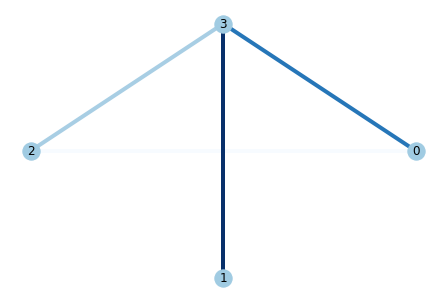

In [4]:
g1 = graph_from_hamiltonian(h1)
plot_graph(g1)

<a id='hamiltonian_from_graph'></a>

#### Graphs to Hamiltonians
Alternatively, we can work backwards, creating a graph first, then the corresponding Hamiltonian using the `hamiltonian_from_graph()` method. 

Let's take the graph we have just produced (`g1`) and convert it back to its corresponding Hamiltonian, which we called `h1` above.

In [5]:
H1 = hamiltonian_from_graph(g1)
print('From graph:', H1)
print('')
print('Original:', h1)

From graph: (0.5801409086051283+0j)*Z0 + (0.12998939263198905+0j)*Z3 + (0.09763731752550098+0j)*Z0*Z2 + (0.47755355462221494+0j)*Z0*Z3 + (0.6193108013744926+0j)*Z3*Z1 + (0.27718860994258887+0j)*Z3*Z2

Original: (0.5801409086051283+0j)*Z0 + (0.12998939263198905+0j)*Z3 + (0.09763731752550098+0j)*Z0*Z2 + (0.47755355462221494+0j)*Z0*Z3 + (0.6193108013744926+0j)*Z1*Z3 + (0.27718860994258887+0j)*Z2*Z3


<a id='graph_from_hyperparams'></a>

#### Hyperparameters to Graphs
We can also create a graph directly from hyperparameters, using the `graph_from_hyperparams()` method. Here we use the Hamiltonian created [above](#hyperparams_to_ham).

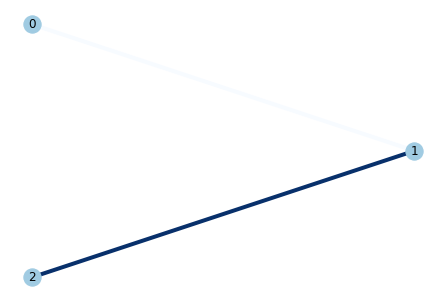

In [6]:
g0 = graph_from_hyperparams(nqubits, singles, biases, pairs, couplings)
plot_graph(g0)

<a id='random_k_regular_graph'></a>

#### Random, regular Graphs
In recent research on QAOA, there has been interest in the performance of the algorithm on $k$-regular graphs, i.e. graphs where every node is connected to exactly $k$ other nodes. We can generate such graphs easily using the `random_k_regular_graph()` function. For instance, let's create a 3-regular graph with 8 nodes: 

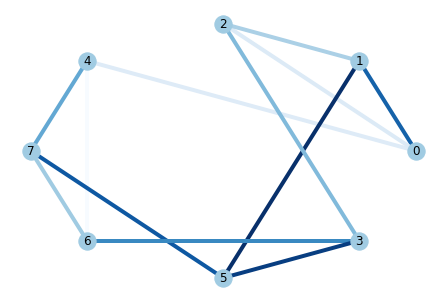

In [7]:
G_3_reg = random_k_regular_graph(3, range(8), weighted=True)
plot_graph(G_3_reg)

<a id='hamiltonians_and_data'></a>

## Hamiltonians and data

One prominent application of QAOA is to solve the weighted MaxCut problem, which may be used as a clustering technique - see, for example, [Ref 1](#references). Here, the pairwise distance between a given pair of data points in a dataset is used as the weight on the corresponding graph, and enters the Hamiltonian as the corresponding coupling coefficient between the corresponding qubits.

In the following, we demo some steps of a workflow to use QAOA to solve such a MaxCut problem for clustering. We use simple toy data generated by the `gaussian_2Dclusters()` function.

<a id='gaussian_2Dclusters'></a>

#### Cluster generation and distance calculations

 Let's create a data set of two clusters, where the points in each cluster follow Gaussian statistics.

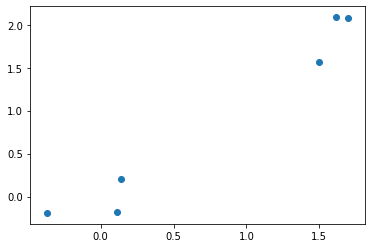

In [8]:
n_clusters = 2 # Number of clusters we want 
n_points = [3,3] # Number of data points in each cluster
means = [[0,0], [2,2]] # Cluster means (the [x,y] coordinates of each cluster centre)

# Covariance matrix: we will use the same one for each of the two clusters here,
# but more generally they could be different
cov_matrix = [[0.1, 0], [0, 0.1]] 
cov_matrices = [cov_matrix,cov_matrix]

cluster_data = gaussian_2Dclusters(n_clusters,n_points,means,cov_matrices)
plot_cluster_data(cluster_data)

The next step in setting up the MaxCut problem is to compute the pairwise distances of the points in the dataset, which we can do using the `distances_dataset()` function. Here we will use the Euclidean distance, but more generally we can ask for any distance metric included in Scipy's [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) function.

In [9]:
dists = distances_dataset(cluster_data, metric='euclidean')
dists

array([[0.        , 0.38676505, 0.64366626, 1.92081505, 2.43664812,
        2.39241442],
       [0.38676505, 0.        , 0.47932244, 2.22959423, 2.76165482,
        2.72319262],
       [0.64366626, 0.47932244, 0.        , 2.56038071, 3.06796416,
        3.02030094],
       [1.92081505, 2.22959423, 2.56038071, 0.        , 0.55134331,
        0.5364084 ],
       [2.43664812, 2.76165482, 3.06796416, 0.55134331, 0.        ,
        0.08340936],
       [2.39241442, 2.72319262, 3.02030094, 0.5364084 , 0.08340936,
        0.        ]])

Note that `distances_dataset()` can also take and return data in the Pandas dataframe format.

<a id='hamiltonian_from_distance_matrix'></a>

#### Distance datasets to Hamiltonians

Now that we have the distances between all points in the dataset, we want to generate the corresponding MaxCut Hamiltonian. We can do this easily with the `hamiltonian_from_distances()` method. 

In [10]:
hData = hamiltonian_from_distances(dists)
print(hData)

(0.38676505234418374+0j)*Z0*Z1 + (0.6436662616746497+0j)*Z0*Z2 + (1.9208150540942497+0j)*Z0*Z3 + (2.4366481238675783+0j)*Z0*Z4 + (2.3924144199072104+0j)*Z0*Z5 + (0.47932243702670124+0j)*Z1*Z2 + (2.2295942303685425+0j)*Z1*Z3 + (2.761654820505215+0j)*Z1*Z4 + (2.723192615685079+0j)*Z1*Z5 + (2.5603807135697023+0j)*Z2*Z3 + (3.0679641555183745+0j)*Z2*Z4 + (3.020300942616175+0j)*Z2*Z5 + (0.5513433090092456+0j)*Z3*Z4 + (0.536408398834585+0j)*Z3*Z5 + (0.08340936369005367+0j)*Z4*Z5


For simplicity here we have omitted terms proportional to the identity matrix, which are commonly included in the definition of the MaxCut cost function. Since such terms only introduce a global energy shift, they do not affect the optimal configuration that we find as a solution.

<a id='qaoa_clustering'></a>

## Example 1: Using QAOA to solve MaxCut for the clustering problem

Now that we have the Hamiltonian, we can go ahead and run the QAOA to check that the points are clustered correctly. We will use the `ExtendedParams` class, and three timesteps (p=3). We don't include any single-qubit bias terms.

In [11]:
n_qubits = 6
p = 3

# Specify some angles
betas = np.random.rand(n_qubits,p)
gammas_singles = []
gammas_pairs = np.random.rand(len(hData),p)
parameters = (betas,gammas_singles,gammas_pairs)

extended_params = ExtendedParams([hData,p],parameters)

# NOTE - the optimiser will reach its maximum number of iterations, but for the parameters being used here,
# the choice maxiter=200 seems to be more than sufficient to get to the optimum with high probability.
cost_function = QAOACostFunctionOnWFSim(hData,
                                        params=extended_params,
                                        scalar_cost_function=False)

res = minimize(cost_function, extended_params.raw(),
               tol=1e-3, method="Cobyla", options={"maxiter": 200})
res

     fun: -10.09955123079244
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 200
  status: 2
 success: False
       x: array([ 1.12602003,  1.61914548,  0.9399495 ,  0.23614259,  1.18551376,
        0.29249101,  0.63873523,  0.51051573,  0.93270342,  0.39420024,
        0.12700218,  1.60896481,  0.10426307,  1.18353012,  0.85151294,
        0.64787356,  0.6584982 ,  1.33838275,  0.80031341, -0.01301961,
        0.26776711,  0.3701222 ,  1.37377245,  1.26113146,  0.6715293 ,
        0.02451597,  1.65640896,  0.0339523 ,  1.64080821,  1.07081115,
        0.02873057,  0.19467249,  0.68660883,  0.91054952, -0.00912106,
        0.22138033,  0.43109925,  0.63635338,  0.78070772,  0.09178786,
        0.34277407,  0.50434972,  0.35728683,  0.72260796,  1.0477094 ,
        0.33151519,  0.48165346,  1.46878413,  0.43320862,  0.63287338,
        0.27416803,  0.22954139,  0.22963598,  1.12387447,  0.33189668,
        0.8146632 ,  0.03601882,  0.2138795

Let us plot the probabilities of the different bitstrings. Since the energies are invariant under a bit flip on all qubits, each bitstring and its complement have identical outcome probabilities.

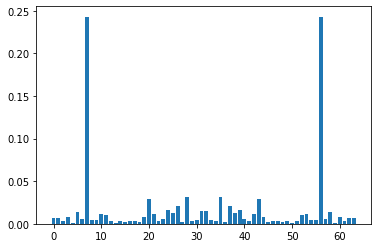

In [12]:
opt_wfn = cost_function.get_wavefunction(res.x)
probs = opt_wfn.probabilities()
plt.bar(range(len(probs)), probs)
plt.show()

Now we want to find the string corresponding to the optimal solution. Numpy's `argmax` function will return the first of the two degenerate solutions. As expected, we find that the first three qubits are in one class, and the second three qubits in another (this is the way the data was constructed above, in two distinct clusters).

In [13]:
optimal_string = np.argmax(probs)
"{0:06b}".format(optimal_string)

'000111'

We can check that the other optimal solution found is the complement bitstring, i.e. 111000:

In [14]:
probs[optimal_string] = 0 # Sets the solution 000111 to have zero probability
optimal_string_complement = np.argmax(probs)
"{0:06b}".format(optimal_string_complement)

'111000'

<a id='ring_of_disagrees'></a>

## Example 2: The Ring of Disagrees 

The _Ring of Diasgrees_ is a 2-regular graph on a given number of nodes $n$. Its simple structure has allowed a number of extremely useful benchmarking results for QAOA to be derived. The ground state has energy $-n$ for even $n$, and $-n+1$ for odd $n$, and neighbouring nodes have opposite values (i.e. if a given node has value 1, its neighbour has value 0). 

In the paper that originally introduced the QAOA ([Ref 2](#references)), it was shown numerically that this graph provides a simple example of how the approximation ratio returned by QAOA can be made arbitrarily close to 1 by increasing the parameter $p$. For the MaxCut problem, the optimal cost function value returned for a given $n$ and $p$ was found to be 

$$
C(n,p) = \left(\frac{2p + 1}{2p + 2}\right)n
$$

This result assumes the `StandardParams` parameterisation, and that the graph is unweighted (all edge weights equal to 1). Here we verify this result using the `ring_of_disagrees()` function. Note that subsequent to [Ref 2](#references), this result has been derived using analytic methods in [Ref 3](#references).

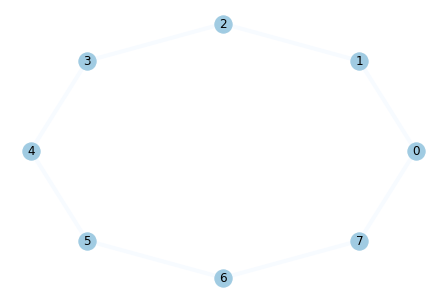

In [15]:
n_nodes = 8
h_disagrees = ring_of_disagrees(n_nodes)
g_disagrees = graph_from_hamiltonian(h_disagrees)
plot_graph(g_disagrees)

In [16]:
def optimise_ring_of_disagrees(pval):
    
    # Initialise angles
    betas = np.random.rand(pval)
    gammas = np.random.rand(pval)
    parameters = (betas, gammas)

    # Set up (hyper)parameters
    disagrees_params = StandardParams([h_disagrees,pval],parameters)
    
    # Cost function and optimisation
    cost_function = QAOACostFunctionOnWFSim(h_disagrees, params=disagrees_params)
    
    res = minimize(cost_function, disagrees_params.raw(),
                   tol=1e-3, method="BFGS", options={"maxiter": 500})
    
    return res.fun, res.x
    

p_vals = np.arange(1,5) # p range to consider
output_val = np.zeros((len(p_vals),))
for i in p_vals:

    output_val[i-1] = optimise_ring_of_disagrees(i)[0]

Since we have 8 qubits, according to Farhi's formula we should find the maximum energy to be $-8 \cdot (3/4,5/6,7/8,9/10) = -(6, 6.67, 7, 7.2)$ for $p = (1,2,3,4)$:

In [17]:
output_val

array([-6.        , -6.66666667, -6.99999999, -7.99999999])

For the case $p=1$, the optimal angles can be computed analytically, and are given by $(\beta_{opt}, \gamma_{opt}) = (\pi/8, \pi/4$) - see [Ref 4](#references). We can see that the optimiser does indeed return these angles:

In [18]:
opt_angles = optimise_ring_of_disagrees(1)[1]
opt_angles

array([0.39271096, 0.78538447])

Let's finish off by running an example of the Ring of Disagrees on the QVM; we would follow a similar method to run the computation on the QPU. We'll use the optimal angles we have just found to check that the probability distribution of samples we obtain does indeed return the bitstring [0,1,0,1], or its complement [1,0,1,0], with high probability. 

Here, we make use of the `sample_qaoa_bitstrings` function, which executes the circuit defined by the QAOA instance and samples from output multiple times. We can plot the output conveniently using `bitstring_histogram`. 

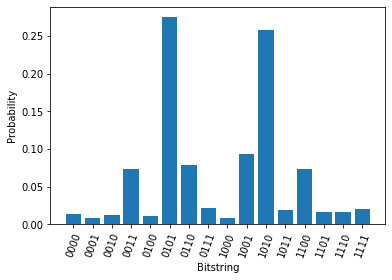

In [19]:
qvm = get_qc("4q-qvm")

ham_disagrees_4 = ring_of_disagrees(4)
params_disagrees_4 = StandardParams([ham_disagrees_4,1], opt_angles)

bitstrings = sample_qaoa_bitstrings(params_disagrees_4, qvm)
bitstring_histogram(bitstrings)

<a id='miscellaneous'></a>

## More miscellaneous utilities

Here we demonstrate the functionality of some additional methods that may be useful in certain contexts.

<a id='prepare_classical_state'></a>

#### Different initial states for QAOA

We can easily use an initial state different from $\left|+ \cdots +\right>$ for QAOA, by passing a state preparation program for the `initial_state` argument of the QAOA cost functions. For purely classical states (i.e. not a quantum superposition state) such as $\left|10 \cdots 10\right>$, these programs cane be created via `prepare_classical_state`.

In [20]:
register = [0, 1, 2, 3, 4, 5]  # the register to create the state on
state = [1, 0, 1, 0, 1, 0]     # the |42> state (encodes the decimal number 42)

prepare42_circuit = prepare_classical_state(register, state)
print(prepare42_circuit)

X 0
X 2
X 4



<a id='max_probability_bitstring'></a>

#### Get the bitstring corresponding to the maximum probability state

The `max_probability_bitstring()` method returns the bitstring corresponding to the maximum probability state of a wavefunction.

In [21]:
probs = np.exp(-np.linspace(-5, 10, 16)**2) # just an array of length 16 (corresponds to a 4-qubit system)
probs = probs/probs.sum() # normalise to represent a proper probability distribution
max_prob_state = max_probability_bitstring(probs)
print(max_prob_state)

[0, 1, 0, 1]


<a id='cluster_accuracy'></a>

#### Accuracy scores for QAOA 

`cluster_accuracy()` gives accuary scores for a QAOA result, if the true solution is known. The accuracy here is defined as the percentage of bits that are correct compared to the known solution.

In [22]:
cluster_accuracy(max_prob_state, true_labels=[1, 1, 0, 0])

True Labels of samples: [1, 1, 0, 0]
Lowest QAOA State: [0, 1, 0, 1]
Accuracy of Original State: 50.0 %
Accuracy of Complement State: 50.0 %


<a id='plot_probabilities'></a>

#### Get nice plots of probabilties

If the true energies of all states are known, we can also obtain a nice side-by-side plot of the energies and probabilites using `plot_probabilities()`.

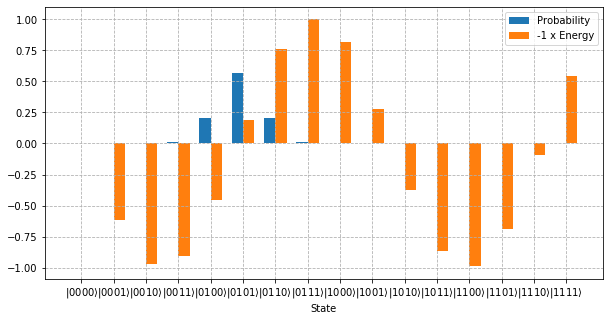

In [23]:
energies = np.sin(np.linspace(0, 10, 16))
fig, ax = plt.subplots(figsize=(10,5))
plot_probabilities(probs, energies, ax=ax)

<a id='references'></a>

## References

1. J. S. Otterbach et al, __[*Unsupervised Machine Learning on a Hybrid Quantum Computer*](https://arxiv.org/abs/1712.05771)__
2. E. Farhi et al, __[*A Quantum Approximate Optimization Algorithm*](https://arxiv.org/abs/1411.4028)__
3. Z. Wang et al, __[*The Quantum Approximation Optimization Algorithm for MaxCut:  A FermionicView*](https://arxiv.org/pdf/1706.02998.pdf)__
4. S. Hadfield, __[*Quantum Algorithms for Scientific Computing andApproximate Optimization*](https://arxiv.org/pdf/1805.03265.pdf)__